## Homework 2 (Zillow Challenge: Kaggle).
### BY: Anjul Kumar Tyagi (111482304)
This homework is about exploring the Properties data-set provided by Zillow and get insights from the data. We will discuss the solution with each part in details below.

#### Part 1
Part-I of the question is mainly about getting correlation between interesting features.

I will to find the correlation between the following properties.
 - Bedroom Count
 - Building Quality Type
 - Calculated Finished Square Feet
 - Number of Stories
 - Lot size
 - Tax Amount
 
I've chosen only **6** features out of all because it'll be easy to analyze the correlation matrix between these features. Moreover, the features which have some **id** associated with them are dropped because they don't follow
any sequence w.r.t other features.

We will make use of **Pandas, Numpy, Matplotlib, Seaborn, Scikit Learn and Scipy** libraries in Python. 

- Pandas: It is used for working with large tabular data and allow easy date manipulation.
- Numpy: Python library for performing mathematical operations on data.
- Matplotlib: Used for data visualization.
- Seaborn: Used for plotting heatmap for the 1st part of this homework.
- Sklearn: Used for performing training of data with different models of machine learning.
- Scipy: For statistical inference from data

We shall first import all useful libraries.

In [1]:
import pandas as pd
import numpy as np
import seaborn.apionly as sns
import matplotlib.pyplot as plt
from sklearn import linear_model, preprocessing
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import  make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR
from scipy import stats

The next step is to read the data file given in the file **properties_2016.csv** file placed inside the **data** folder. We shall first read the columns that we require for plotting the correlation matrix.

In [2]:
data = pd.read_csv('data/properties_2016.csv', usecols=['parcelid',
                                                        'bedroomcnt',
                                                        'buildingqualitytypeid',
                                                        'calculatedfinishedsquarefeet',
                                                        'numberofstories',
                                                        'lotsizesquarefeet',
                                                        'taxamount',
                                                        ], index_col='parcelid')

/home/tyagi/anaconda/lib/python2.7/site-packages/numpy/lib/arraysetops.py:395: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


The above data is missing the **logerror and date** values. For that, we need to read another file named **train_2016.csv** placed inside the **data** folder. After reading the file, we can join this with the original data.

For the **transactiondate** field, only the **month** is included which is extracted by slicing the date string, as shown below in second line.

In [3]:
logerror_data = pd.read_csv('data/train_2016_v2.csv', usecols=['parcelid','logerror', 'transactiondate'], index_col='parcelid')
logerror_data['transactiondate'] = pd.to_numeric(logerror_data['transactiondate'].str[5:7])

**Outer join** is used so that the new *dataframe* contains the **union** of the **parcelid** in the two data frames.

In [4]:
data = data.join(logerror_data, how='outer')

For easy representation of the column names in the correlation heatmap, we will give shorter names to the columns using the **rename** command.

In [5]:
data_renamed = data.rename(index=str, columns={'bedroomcnt':'BedCnt',
                                       'buildingqualitytypeid':'BldnQlty',
                                       'calculatedfinishedsquarefeet':'sqFeet',
                                       'numberofstories':'Stories',
                                       'lotsizesquarefeet':'lotsize',
                                       'taxamount':'tax',
                                       'transactiondate':'sellDate'})

**corr** command computes **pairwise** pearson correlation between all features given in the dataframe **data_renamed.**

In [6]:
corr = data_renamed.corr()

For including both **pearson correlation** and **heatmap** on the same plot, the following code segment is used from the source[https://stackoverflow.com/questions/43507756/python-seaborn-how-to-replicate-corrplot]

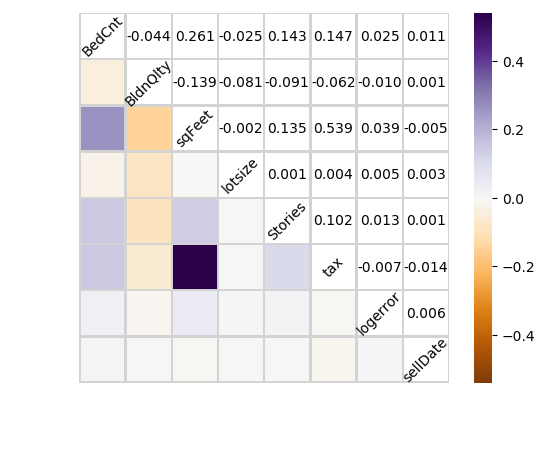

In [7]:
mask = np.zeros_like(corr, dtype=np.bool) # returns an array of zeros of the same shape and size as corr mat
mask[np.triu_indices_from(mask)] = True # makes the upper triangle of mask as 1

# Set up the matplotlib figure
fig, ax = plt.subplots()

# Draw the heatmap with the mask and correct aspect ratio
vmax = np.abs(corr.values[~mask]).max()
sns.heatmap(corr, mask=mask, cmap=plt.cm.PuOr, vmin=-vmax, vmax=vmax,
            square=True, linecolor="lightgray", linewidths=1, ax=ax) # Masks the upper triangle of the heatmap
for i in range(len(corr)):
    ax.text(i+0.5,len(corr)-(i+0.5), corr.columns[i], 
            ha="center", va="center", rotation=45)
    for j in range(i+1, len(corr)):
        s = "{:.3f}".format(corr.values[i,j])
        ax.text(j+0.5,len(corr)-(i+0.5),s, 
            ha="center", va="center")
ax.axis("off")
plt.show()

Some important observation from the above correlation matrix are:

- **Tax Amount and Total Square feet of the building** are highly correlated with the value 0.539.
- **Building Quality** is negatively correlated to all other features taken into account, which is interesting.
- Particularly, **building quality being negatively correlated to the Tax amount** is surprising.
- **Number of stories** in a building are positively correlated with both **Total Square feet** of the building and **Tax amount**.
- **Bedroom Count** is highly correlated with the **Total square feet** of the building which is understandable.
- **Log Error** is not heavily correlated with any of the features, with maximum being with **Square Feet**.

However, in general, no features can be used to significantly derive the logerror value based on the correlation.

#### Part 2

This part is about getting some more information about the features in the data using different plots. We will remove the **parcelid** from our dataframe now and instead replace it with the sequential index starting from number **0** for easy data manipulation.

In [8]:
data_without_index = data_renamed.reset_index()

#### Fig-1 (Scatter plot - Total Square Feet)
To see how a feature is distributed, a scatter plot can give useful information about that feature. We can see outliers in the data and how the data points are related to each other. 

The first line removes the **Nan** values from the data column. Second row filters the data for selecting houses only with **area > 100 sq.ft.**

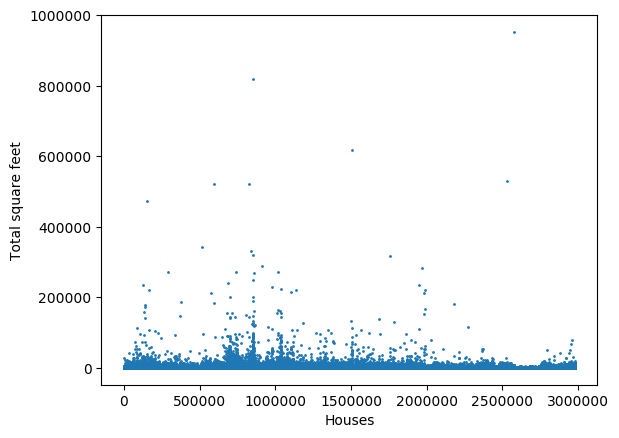

In [9]:
sqFeet = data_without_index['sqFeet'][np.logical_not(np.isnan(data_without_index['sqFeet']))]
sqFeet = sqFeet[sqFeet > 100]
plt.plot(sqFeet,'o', ms=1) #ms is an alias for marker size
plt.xlabel('Houses')
plt.ylabel('Total square feet')
plt.show()

The above figure doesn't provide much useful information except depicting where the outliers are and which part, the data is mostly located. For better representation, the number of houses can be reduced along with removing the outliers. 

For the next plot, we select **500** apartments with the **range of the sq.ft.** to be between **[100,10000].**

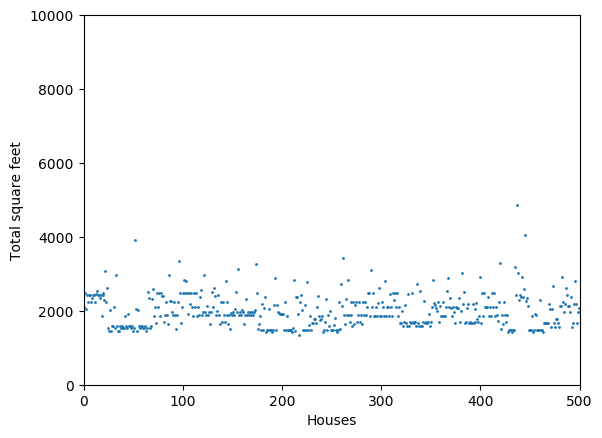

In [10]:
plt.plot(sqFeet,'o', ms=1) #ms is an alias for marker size
plt.xlabel('Houses')
plt.ylabel('Total square feet')
axes = plt.gca() # Stands for get the current axis
axes.set_ylim([0,10000])
axes.set_xlim([0,500])
plt.show()

Now this scatter plot is much more informative. It clearly shows that most houses are between **1000 - 3000 sq. feet**.

#### Fig-2 (Pie Chart - Which county has how many apartments)
The data includes three counties namely **Los Angeles, Orange and Ventura** for which the apartment data is collected. From the **regionidcounty** feature of the data, information of number of houses in each of the above counties can be derived.

**value_counts** function of **pandas** can be used to calculate how many times different **regionidcounty** are occurring in the data. 

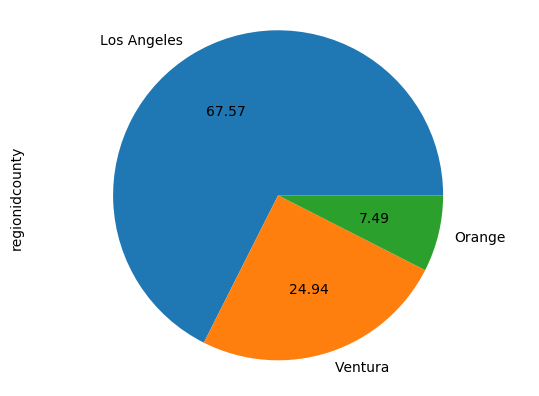

In [11]:
county_arch = pd.read_csv('data/properties_2016.csv', usecols=['regionidcounty','architecturalstyletypeid'])
county_arch['regionidcounty'] = county_arch['regionidcounty'].replace([3101.0, 2061.0, 1286.0],
                                                                      ['Los Angeles', 'Orange', 'Ventura'])
county_arch['regionidcounty'].value_counts(normalize=False, sort=True, dropna=True).plot(kind='pie',autopct='%.2f')
plt.axis('equal')
plt.show()

#### Fig-3 (Pie Chart - Architectural Styles)
Similar to Fig-2, this figure explores the architectural styles of the apartments in the counties with the help of the column **architecturalstyletypeid**. Since this is an **id** field, we didn't use this for the correlation data.

Since there are many architectural styles, we decide the explore the **top 4** styles and see how much percentage of apartments have them.

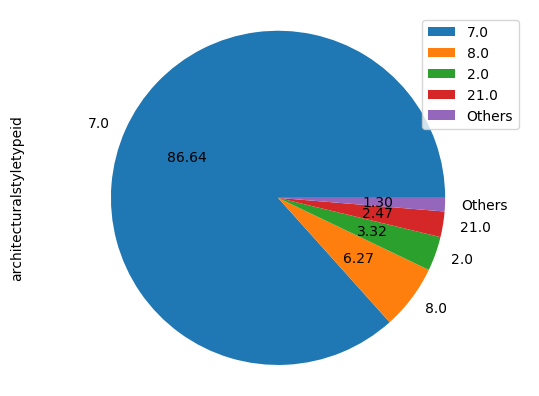

In [12]:
county_arch_temp = county_arch['architecturalstyletypeid'].value_counts(normalize=False, sort=True, dropna=True)
county_arch_small_values_clubbed = county_arch_temp.head(4)
county_arch_temp = county_arch_temp.reset_index(drop=True)
# Sum all other architectural styles which are not dominant.
if len(county_arch_temp) > 4:
    county_arch_small_values_clubbed['Others'] = county_arch_temp[4:].sum()
county_arch_small_values_clubbed.plot(kind='pie',autopct='%.2f')
plt.legend()
plt.axis('equal')
plt.show()

#### Fig-4 (Line chart - Distribution of Total area vs. Tax amount)
The correlation between **Total area** and **Tax amount** was about **0.539** which is among the highest of all features. So, it'll be interesting to see on a plot how the total_area change with the tax_amount. 

Since the tax values are large, they are represented by dividing by **1000000** on the plot. Also, because mostly the **area** is distrubuted in a small range, we only consider the area points below **17000 sq.ft.**

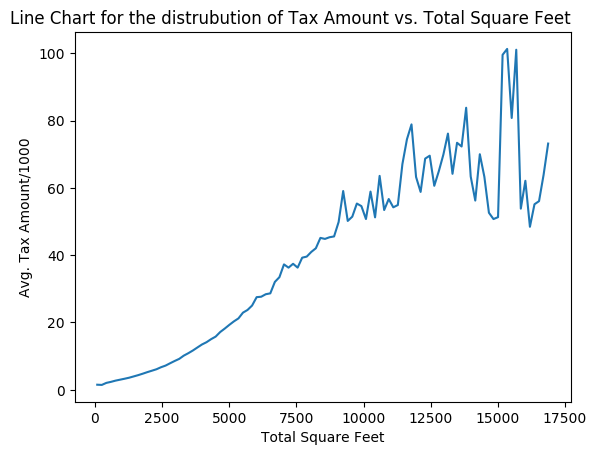

In [13]:
area_tax = pd.concat([data_without_index['sqFeet'], data_without_index['tax']], axis=1, keys=['sqFeet', 'tax'])
area_tax['tax'] = area_tax['tax']/1000
area_tax['sqFeet'] = area_tax[area_tax['sqFeet'] < 17000]['sqFeet']
area_tax = area_tax.dropna(axis=0, how='any')
# Counting the tax amount for houses in a small range of areas.
y,binEdges=np.histogram(area_tax['sqFeet'], weights=area_tax['tax'],bins=100)
y_area, bin_area = np.histogram(area_tax['sqFeet'], bins=100)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.plot(bincenters,y/y_area,'-')
plt.xlabel('Total Square Feet')
plt.ylabel('Avg. Tax Amount/1000')
plt.title('Line Chart for the distrubution of Tax Amount vs. Total Square Feet', loc='right')
plt.show()

The Tax Amount rises with the rise in area of the apartment and there is a suddent height at around 15000 sq.ft. which is probably because of lack of data points.

#### Fig-5 (Histogram - How many houses are sold each month)
The next histogram is interesting as it shows how the sale of properties vary over an year. The sales go high at the end of the financial year i.e. after March till June and remain high until November. **November and December** are low on sales maybe because are celebrating winter.

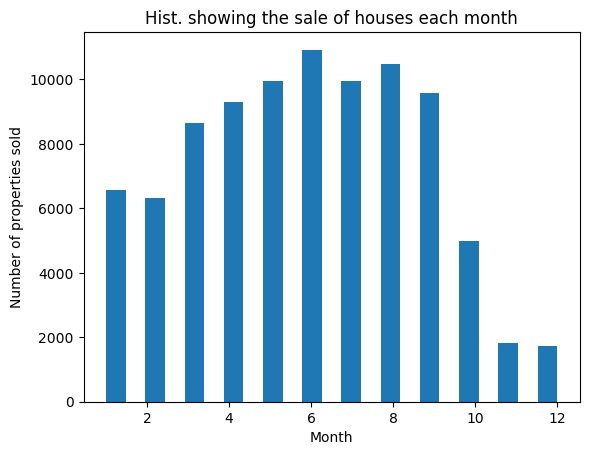

In [14]:
area_error = data_without_index['sellDate']
area_error = area_error.dropna()
plt.hist(area_error,bins=23)
plt.xlabel('Month')
plt.ylabel('Number of properties sold')
plt.title('Hist. showing the sale of houses each month', loc='center')
plt.show()

#### Part 3 Linear Regression

Linear Regression tries to fit a line through all the data points. For simplicity, we'll start with only **one feature** i.e. *Area*, and we'll try to predict the logerror with the area. Linear regression returns the slope and the intercept of the line that best fits the data points.

In [15]:
# Preparing a dataframe with Sq.Feet and logerror
reg_area_error = pd.concat([data_without_index['sqFeet'], data_without_index['logerror']], axis=1, keys=['sqFeet', 'logerror'])
# Filter the sq.Feet for outliers
reg_area_error['sqFeet'] = reg_area_error[reg_area_error['sqFeet'] < 17000]['sqFeet']
# Remove rows with Nan values
reg_area_error = reg_area_error.dropna(axis=0, how='any')
# Apply linear regression
result = np.polyfit(reg_area_error['sqFeet'], reg_area_error['logerror'],1)
print result

[  6.86225733e-06  -6.01900755e-04]


Lets see how the predicted line looks with the data points.

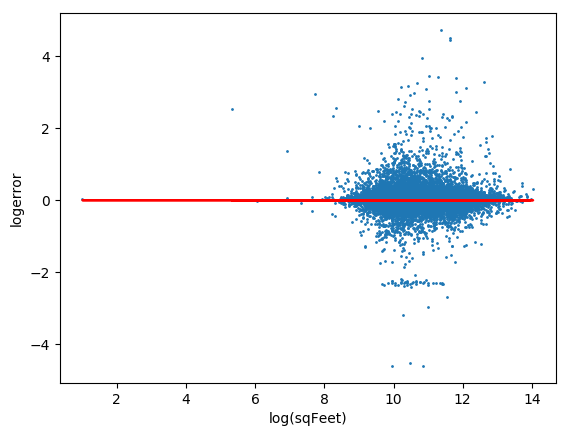

In [16]:
plt.plot(np.log2(reg_area_error['sqFeet']), reg_area_error['logerror'], 'o', ms=1)
plt.plot(np.log2(reg_area_error['sqFeet']), np.polyval(result, np.log2(reg_area_error['sqFeet'])), 'r-')
plt.xlabel('log(sqFeet)')
plt.ylabel('logerror')
plt.show()

It is clear that line tries to fit through all the data points and hence, passes through almost center of the data. However, it is to be noted that the **outliers have greatly affected the slope of the line**. We will try to improve that by removing the outliers in the next steps. 

First, we'll try linear regression on all factors. We will start by adding more features to the **data**.

In [17]:
more_features = pd.read_csv('data/properties_2016.csv', usecols=['parcelid',
                                                        'basementsqft',
                                                        'bathroomcnt',
                                                        'fireplacecnt',
                                                        'garagecarcnt',
                                                        'garagetotalsqft',
                                                        'poolcnt',
                                                        'poolsizesum',
                                                        'yearbuilt'         
                                                        ], index_col='parcelid')

Join the **more_features** dataframe to the **data**.

In [18]:
data = data.join(more_features, how='outer')

Now let's see how many values we have after dropping the rows that contain any **Nan** values.

In [19]:
data_dropped_nan = data.dropna(axis=0, how='any')
print data_dropped_nan

Empty DataFrame
Columns: [bedroomcnt, buildingqualitytypeid, calculatedfinishedsquarefeet, lotsizesquarefeet, numberofstories, taxamount, logerror, transactiondate, basementsqft, bathroomcnt, fireplacecnt, garagecarcnt, garagetotalsqft, poolcnt, poolsizesum, yearbuilt]
Index: []


Because we added too many features into our Linear regression matrix, there is not a single row in our data that doesn't have a **Nan**. For simplicity, we will now try by **replacing Nan with the mean** of the columns and then see how well does Linear Regression performs.

In [20]:
# Fill Nan with mean
data_without_nan = data.drop(['logerror', 'transactiondate'],1).fillna(data.mean())
data_without_nan = data_without_nan.join(logerror_data, how='outer')
# Drop all the rows with Nan i.e. rows that don't have a logerror associated
data_without_nan = data_without_nan.dropna(axis=0, how='any')
# Drop the index for simplicity
data_without_nan_noindex = data_without_nan.reset_index()
data_without_nan_noindex = data_without_nan_noindex.drop('parcelid',1)

After we've the data ready, we can split the data into **training** and **testing** part as shown below. Then we can test our linear regression model on multiple features.

In [21]:
data_without_logerror = data_without_nan_noindex.drop('logerror',1)
logerror = data_without_nan_noindex['logerror']
# Split the training and testing data
train_x = data_without_logerror.iloc[:45000,:]
test_x = data_without_logerror.iloc[45000:,:]
train_y = logerror.iloc[:45000]
test_y = logerror.iloc[45000:]
# Prepare the Linear Regression model
regr = linear_model.LinearRegression()
regr.fit(train_x, train_y)
print train_x.columns
print regr.coef_

Index([u'bedroomcnt', u'buildingqualitytypeid',
       u'calculatedfinishedsquarefeet', u'lotsizesquarefeet',
       u'numberofstories', u'taxamount', u'basementsqft', u'bathroomcnt',
       u'fireplacecnt', u'garagecarcnt', u'garagetotalsqft', u'poolcnt',
       u'poolsizesum', u'yearbuilt', u'transactiondate'],
      dtype='object')
[ -6.64395242e-05   6.59376821e-04   1.20776753e-05   4.91596242e-09
  -9.50221900e-01  -1.14899031e-06  -2.02355493e-15  -8.94630456e-04
  -1.38916656e-14   7.39751347e-07  -1.60858503e-03   0.00000000e+00
  -3.06758114e-25   1.30961605e-04   3.84926107e-04]


Shown above are the weights which the linear regression model has assigned to each feature. **The maximum weight** is assigned to **number of stories** with an absolute value of **9.5022**, which means that **number of stories is the most important factor.** We can now test our trained model on the test data and get the **mean squared error and r^2 error** values, which are shown below.

In [22]:
predict_y = regr.predict(test_x)
print mean_squared_error(test_y, predict_y)
print r2_score(test_y, predict_y)

0.272064302452
-11.5104617076


The mean squared erro value is high along with the r^2 value, which means that the linear regression model didn't perform well on the testing data. That's understandable because our data is trained for **outliers and the data is not normalized**. In the next part, we remove the outliers and normalize the **continuous** variables in our model to see what changes the linear regression brings.
#### Part 4

Because **r^2 score is highly dependent on number of features**, first we try to reduce the number of features. The biggest trouble with our data is that we've replced the **Nan** with the **mean** of columns which isn't performing well enough. Now we filter our data to only have features that have real values and use them to train the linear regression.

In [23]:
data_dropped_nans = data
# Dropping columns that have more than 300000 Nan values
for col in data_dropped_nans:
    if data_dropped_nans[col].isnull().sum() > 300000:
        data_dropped_nans = data_dropped_nans.drop(col,1)
data_dropped_nans = data_dropped_nans.join(logerror_data, how='outer')
data_dropped_nans = data_dropped_nans.dropna(axis=0, how='any')
data_dropped_nans_noindex = data_dropped_nans.reset_index()
data_dropped_nans_noindex = data_dropped_nans_noindex.drop('parcelid',1)

Now we're only left with features: **Bedroom count, calculated finished square feet, lot size square feet, tax amount, bathroom count and year built, logerror and transaction date.** This time, we don't need to replace the **Nan** because there aren't any. Seperating the data into training and testing with this new data may give better results.

In [24]:
data_dropped_nans_error = data_dropped_nans_noindex.drop('logerror',1)
logerror = data_dropped_nans_noindex['logerror']
train_x = data_dropped_nans_error.iloc[:45000,:]
test_x = data_dropped_nans_error.iloc[45000:,:]
train_y = logerror.iloc[:45000]
test_y = logerror.iloc[45000:]
regr = linear_model.LinearRegression()
regr.fit(train_x, train_y)
print data_dropped_nans_error.columns
print regr.coef_

Index([u'bedroomcnt', u'calculatedfinishedsquarefeet', u'lotsizesquarefeet',
       u'taxamount', u'bathroomcnt', u'yearbuilt', u'transactiondate'],
      dtype='object')
[ -1.69978917e-03   1.48706341e-05   6.85596813e-09  -1.15054341e-06
  -2.79953026e-03   1.30662769e-04   3.30287482e-04]


This time, the most important factor turned out to be **bathroom count** with the weight of **0.002** in absolute value. After training, we can test the linear regression. Below are the results.

In [25]:
predict_y = regr.predict(test_x)
print mean_squared_error(test_y, predict_y)
print r2_score(test_y, predict_y)

0.0219963834815
0.0003866961375


As clear, the **mean square error and r^2 value have considerably reached below zero.** This model is certainly better than the previous one. We can have a look at the residual plot below for the above regression on filtered data.

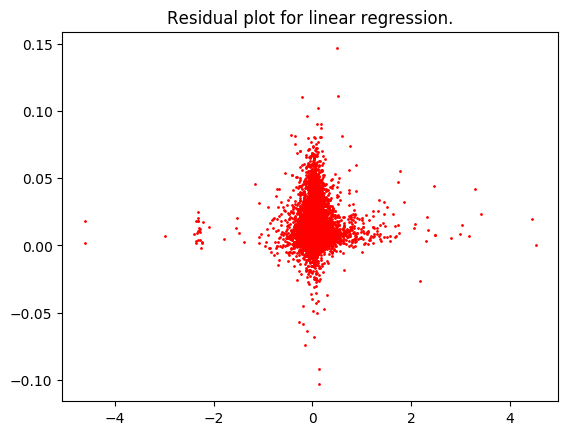

In [26]:
plt.plot(test_y,predict_y,'ro', ms=1)
plt.title('Residual plot for linear regression.')
plt.show()

All of the above methods include Linear Regression, however, this data may fit better with a lon linear model. For this purpose, we've used **non-linear regression** to fit the data in the code below.

However, first we will remove the outliers and normalize all the fields for this operation.

In [27]:
final_data_noerror = data_dropped_nans.drop(['logerror','transactiondate'],1)
# Removing the outliers with distance farther than 3*std-dev from mean
final_data_noerror_no_outlier = final_data_noerror[(np.abs(stats.zscore(final_data_noerror)) < 3).all(axis=1)]
final_data_no_outlier = final_data_noerror_no_outlier.join(logerror_data, how='outer')
final_data_no_outlier = final_data_no_outlier.dropna(axis=0, how='any')
final_data_no_outlier_noindex = final_data_no_outlier.reset_index()
final_data_no_outlier_noindex = final_data_no_outlier_noindex.drop('parcelid',1)

Now we'll normalize the data in the cells except the fields that have discrete values.

In [28]:
min_max_scalar = preprocessing.MinMaxScaler()
np_scaled = min_max_scalar.fit_transform(final_data_no_outlier_noindex)
final_data_normalized = pd.DataFrame(np_scaled)
final_data_normalized[6] = final_data_no_outlier_noindex['logerror']
final_data_normalized[7] = final_data_no_outlier_noindex['transactiondate']
final_data_normalized[0] = final_data_no_outlier_noindex['bedroomcnt']
final_data_normalized[4] = final_data_no_outlier_noindex['bathroomcnt']
final_data_normalized[5] = final_data_no_outlier_noindex['yearbuilt']

Now that we've removed the outliers and normalized the data, let's apply polynomial regression on this model.

In [29]:
final_data_svr = final_data_normalized.drop(6,1)
logerror = final_data_normalized[6]
train_x = final_data_svr
test_x = final_data_svr
train_y = logerror
test_y = logerror

In [30]:
# Defining the Polynomial regression for degree 3
clf = make_pipeline(PolynomialFeatures(3), Ridge())
clf.fit(train_x, train_y)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [31]:
predict_y = clf.predict(test_x)
print mean_squared_error(test_y, predict_y)
print r2_score(test_y, predict_y)

0.0245495617902
0.00982893137855


The **mean square error** is comparable to the linear regression but the **r square** value is higher than the Linear regression i.e. more towards **1**, which means that this model has better predicting power.

However, we didn't try linear regression on the normalized data, let's do that in the following code and then we'll compare the results of **polynomial regression vs. linear regression.**

In [32]:
regr = linear_model.LinearRegression()
regr.fit(train_x, train_y)
print data_dropped_nans_error.columns
print regr.coef_

Index([u'bedroomcnt', u'calculatedfinishedsquarefeet', u'lotsizesquarefeet',
       u'taxamount', u'bathroomcnt', u'yearbuilt', u'transactiondate'],
      dtype='object')
[ -1.50658676e-03   5.99907298e-02   7.08541156e-03  -7.22604176e-02
   1.81044903e-03   3.51519129e-05   2.30566143e-04]


This time, **tax amount** has the highes absolute weight of **0.0722** after removing outliers and normalization.

In [33]:
predict_y = regr.predict(test_x)
print mean_squared_error(test_y, predict_y)
print r2_score(test_y, predict_y)

0.0246944107389
0.00398665852805


Now compairing Linear regression vs. Polynomial regression, we find that the **mean squared error** remains almost the constant but **polynomial regression** has higher r^2 value which implies that it has better predicting power than linear regression. With this idea, we'll go on to submit a solutions file to **Kaggle.**

#### Part 5.
We'll start with building a test file for which we'll generate the test output to submit.

In [34]:
final_test_mat = data.filter(['bedroomcnt',
                      'calculatedfinishedsquarefeet',
                      'lotsizesquarefeet',
                      'taxamount',
                      'bathroomcnt',
                      'yearbuilt',
                      'transactiondate'
                     ],axis=1)
final_test_mat = final_test_mat.reset_index()
final_test_mat = final_test_mat.drop('parcelid',1)

In [35]:
# Replacing Nan with zeros in the final test file. Because a zero will not affect the linear regression
# for that feature.
final_test_mat = final_test_mat.fillna(0)
# Normalizing the input data
np_scaled = min_max_scalar.fit_transform(final_test_mat)
final_test_normal = pd.DataFrame(np_scaled)
# Put back the values for discrete values which weren't to be normalized
final_test_normal[0] = final_test_mat['bedroomcnt']
final_test_normal[4] = final_test_mat['bathroomcnt']
final_test_normal[5] = final_test_mat['yearbuilt']
final_test_10 = final_test_11 = final_test_12 = final_test_normal
# We've generated three test files for the months of oct, nov and dec.
# 6th column is the transactiondate column in the normalized data frame.
# Setting the date column to respective months.
final_test_10[6] = 10.0
final_test_11[6] = 11.0
final_test_12[6] = 12.0

After generating the final test files for each month, we'll predict the output using the trained **polynomial regression** model. We will also do this for **linear regression** model.

In [36]:
predict_10 = clf.predict(final_test_10)
predict_11 = clf.predict(final_test_11)
predict_12 = clf.predict(final_test_12)

In [37]:
# convert the predicted outcomes to data frames
df_201610= pd.DataFrame({'201610': predict_10})
df_201710= pd.DataFrame({'201710': predict_10})
df_201611= pd.DataFrame({'201611': predict_11})
df_201711= pd.DataFrame({'201711': predict_11})
df_201612= pd.DataFrame({'201612': predict_12})
df_201712= pd.DataFrame({'201712': predict_12})

In [38]:
# Create the final file to submit by concatenating the results into a single dataframe
data_noindex = data.reset_index()
tosubmit = pd.concat([data_noindex['parcelid'],df_201610, df_201611, df_201612, df_201710, df_201711, df_201712], axis=1)
tosubmit = tosubmit.round(4)

In [39]:
# Write the contents to a csv file to submit
tosubmit = tosubmit.rename(index=str, columns={'parcelid':'ParcelId'})
tosubmit = tosubmit.set_index('ParcelId')
tosubmit = tosubmit.reset_index().drop_duplicates(subset='ParcelId', keep='first').set_index('ParcelId')
tosubmit[tosubmit.index.duplicated()]
tosubmit.to_csv('kaggle_output.csv')

,201610,201611,201612,201710,201711,201712
ParcelId,,,,,,


#### Submission Results
- Attempt-1 (Polynomial regression degree 2) Zestimate Score: 0.11478
- Attempt-2 (Polynomail regression degree 3) Zestimate Score: 0.08932
- Attempt-3 (Linear Regression) Zestimate Score: 0.06563

In all the attempts, the one with **Linear Regression** gave the best Zestimate Score with my rank being **2934.**